In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('D:/Major Project/Dataset/Dynamics/A1237_N10deg.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15717 entries, 0 to 15716
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Current(A)      15717 non-null  float64
 1   Voltage(V)      15717 non-null  float64
 2   Temperature(C)  15717 non-null  float64
 3   OCV             15717 non-null  float64
 4   SOC             15717 non-null  float64
dtypes: float64(5)
memory usage: 614.1 KB


In [5]:
data.head()

,Current(A),Voltage(V),Temperature(C),OCV,SOC
0,0.0,2.803019,-8.300812,2.803019,34.0
1,0.0,2.671906,-8.145514,2.671906,23.0
2,0.0,2.689757,-8.223158,2.689757,24.0
3,0.0,2.697759,-8.191391,2.697759,25.0
4,0.0,2.702376,-8.223158,2.702376,25.0


In [6]:
data.describe()

,Current(A),Voltage(V),Temperature(C),OCV,SOC
count,15717.000000,15717.000000,15717.000000,15717.000000,15717.000000
mean,-0.461275,3.081359,-7.811700,3.076746,56.391296
std,0.737010,0.215430,0.806260,0.222318,18.529550
min,-3.840204,2.425685,-9.123863,2.401628,0.000000
25%,-0.920745,2.954136,-8.600811,2.946000,46.000000
50%,-0.457742,3.110487,-7.898536,3.106601,59.000000
75%,0.000191,3.233597,-7.087774,3.233907,69.000000
max,2.061073,3.588770,-6.045685,3.599949,100.000000


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
x = data.iloc[:,:-2]
y = data.iloc[:,-1]

In [9]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [10]:
x = x.reshape(15717,3,1)

In [11]:
x

array([[[0.65074115],
        [0.32442455],
        [0.26738263]],

       [[0.65074115],
        [0.21169622],
        [0.31783367]],

       [[0.65074115],
        [0.2270443 ],
        [0.29260985]],

       ...,

       [[0.39483737],
        [0.18602821],
        [0.13776511]],

       [[0.65051882],
        [0.32495383],
        [0.04134177]],

       [[0.65074115],
        [0.64567342],
        [0.10334777]]])

In [12]:
y = np.array(y).reshape(15717,1)

In [13]:
y

array([[34.],
       [23.],
       [24.],
       ...,
       [19.],
       [34.],
       [65.]])

In [14]:
train_input, test_input, train_soc, test_soc = train_test_split(x,y,test_size=0.2, random_state=42)

In [15]:
for i in range(len(train_soc)):
    if train_soc[i] == 0:
        train_soc[i] = 1

In [16]:
for i in range(len(test_soc)):
    if test_soc[i] == 0:
        test_soc[i] = 1

In [17]:
train_input.shape

(12573, 3, 1)

In [18]:
test_input.shape

(3144, 3, 1)

In [19]:
train_soc.shape

(12573, 1)

In [20]:
test_soc.shape

(3144, 1)

In [21]:
from keras.models import Sequential
from keras.layers import  Dense, RepeatVector, TimeDistributed, GRU,Flatten
from keras.optimizers import Adam

In [22]:
# Define the model
model = Sequential()

# Encoder
model.add(Dense(16, input_shape=(3,1),activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Flatten())

# Repeat the context vector to be the input for the decoder
model.add(RepeatVector(1))

# Decoder
model.add(GRU(64, return_sequences=True,activation='sigmoid'))
model.add(GRU(32, return_sequences=True,activation='sigmoid'))
model.add(GRU(16, return_sequences=True,activation='sigmoid'))
model.add(TimeDistributed(Dense(1, activation='linear')))  # Output sequence for regression

In [23]:
# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [24]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3, 16)             32        
                                                                 
 dense_1 (Dense)             (None, 3, 32)             544       
                                                                 
 dense_2 (Dense)             (None, 3, 64)             2112      
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 192)            0         
 r)                                                              
                                                                 
 gru (GRU)                   (None, 1, 64)             49536     
                                                        

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,mean_absolute_percentage_error
import time

In [26]:
# Train the model
a1 = time.time()
history = model.fit(train_input, train_soc, epochs=500, batch_size=256,validation_split=0.05)
a2 = time.time()
a = a2-a1

Epoch 1/500
47/47 [==============================] - 4s 15ms/step - loss: 3469.2405 - mae: 55.9260 - val_loss: 3344.2202 - val_mae: 54.8489
Epoch 2/500
47/47 [==============================] - 0s 5ms/step - loss: 3290.7847 - mae: 54.3110 - val_loss: 3211.8767 - val_mae: 53.6357
Epoch 3/500
47/47 [==============================] - 0s 4ms/step - loss: 3189.0510 - mae: 53.3730 - val_loss: 3132.1582 - val_mae: 52.8919
Epoch 4/500
47/47 [==============================] - 0s 5ms/step - loss: 3118.2737 - mae: 52.7124 - val_loss: 3068.2014 - val_mae: 52.2876
Epoch 5/500
47/47 [==============================] - 0s 5ms/step - loss: 3057.5498 - mae: 52.1391 - val_loss: 3010.3489 - val_mae: 51.7365
Epoch 6/500
47/47 [==============================] - 0s 5ms/step - loss: 3001.3708 - mae: 51.6046 - val_loss: 2955.9141 - val_mae: 51.2133
Epoch 7/500
47/47 [==============================] - 0s 5ms/step - loss: 2947.9512 - mae: 51.0936 - val_loss: 2903.8486 - val_mae: 50.7103
Epoch 8/500
47/47 [=======

47/47 [==============================] - 0s 9ms/step - loss: 1057.6188 - mae: 28.9512 - val_loss: 1034.9237 - val_mae: 28.5779
Epoch 60/500
47/47 [==============================] - 0s 7ms/step - loss: 1036.3328 - mae: 28.6232 - val_loss: 1013.9562 - val_mae: 28.2546
Epoch 61/500
47/47 [==============================] - 0s 8ms/step - loss: 1015.4637 - mae: 28.2990 - val_loss: 993.4427 - val_mae: 27.9345
Epoch 62/500
47/47 [==============================] - 0s 8ms/step - loss: 995.0240 - mae: 27.9776 - val_loss: 973.3329 - val_mae: 27.6161
Epoch 63/500
47/47 [==============================] - 0s 10ms/step - loss: 974.9975 - mae: 27.6614 - val_loss: 953.6196 - val_mae: 27.3002
Epoch 64/500
47/47 [==============================] - 0s 9ms/step - loss: 955.3964 - mae: 27.3480 - val_loss: 934.3163 - val_mae: 26.9858
Epoch 65/500
47/47 [==============================] - 0s 8ms/step - loss: 936.1890 - mae: 27.0359 - val_loss: 915.4312 - val_mae: 26.6772
Epoch 66/500
47/47 [=====================

47/47 [==============================] - 0s 7ms/step - loss: 392.5023 - mae: 16.3597 - val_loss: 383.8689 - val_mae: 16.2504
Epoch 119/500
47/47 [==============================] - 0s 8ms/step - loss: 389.1034 - mae: 16.2694 - val_loss: 380.5935 - val_mae: 16.1648
Epoch 120/500
47/47 [==============================] - 0s 7ms/step - loss: 385.8656 - mae: 16.1806 - val_loss: 377.4893 - val_mae: 16.0807
Epoch 121/500
47/47 [==============================] - 0s 7ms/step - loss: 382.7925 - mae: 16.0930 - val_loss: 374.5336 - val_mae: 16.0002
Epoch 122/500
47/47 [==============================] - 0s 8ms/step - loss: 379.8700 - mae: 16.0152 - val_loss: 371.7982 - val_mae: 15.9254
Epoch 123/500
47/47 [==============================] - 0s 7ms/step - loss: 377.1216 - mae: 15.9386 - val_loss: 369.1559 - val_mae: 15.8504
Epoch 124/500
47/47 [==============================] - 0s 7ms/step - loss: 374.5113 - mae: 15.8630 - val_loss: 366.6827 - val_mae: 15.7773
Epoch 125/500
47/47 [====================

Epoch 177/500
47/47 [==============================] - 1s 11ms/step - loss: 341.4541 - mae: 14.5261 - val_loss: 336.2445 - val_mae: 14.4462
Epoch 178/500
47/47 [==============================] - 0s 9ms/step - loss: 341.4503 - mae: 14.5237 - val_loss: 336.2447 - val_mae: 14.4436
Epoch 179/500
47/47 [==============================] - 0s 8ms/step - loss: 341.4465 - mae: 14.5223 - val_loss: 336.2454 - val_mae: 14.4415
Epoch 180/500
47/47 [==============================] - 0s 9ms/step - loss: 341.4469 - mae: 14.5198 - val_loss: 336.2468 - val_mae: 14.4392
Epoch 181/500
47/47 [==============================] - 1s 12ms/step - loss: 341.4425 - mae: 14.5192 - val_loss: 336.2470 - val_mae: 14.4389
Epoch 182/500
47/47 [==============================] - 0s 8ms/step - loss: 341.4413 - mae: 14.5178 - val_loss: 336.2481 - val_mae: 14.4377
Epoch 183/500
47/47 [==============================] - 0s 9ms/step - loss: 341.4410 - mae: 14.5168 - val_loss: 336.2485 - val_mae: 14.4373
Epoch 184/500
47/47 [====

Epoch 236/500
47/47 [==============================] - 0s 10ms/step - loss: 341.4396 - mae: 14.5089 - val_loss: 336.2628 - val_mae: 14.4279
Epoch 237/500
47/47 [==============================] - 1s 11ms/step - loss: 341.4433 - mae: 14.5076 - val_loss: 336.2597 - val_mae: 14.4295
Epoch 238/500
47/47 [==============================] - 0s 9ms/step - loss: 341.4394 - mae: 14.5096 - val_loss: 336.2600 - val_mae: 14.4293
Epoch 239/500
47/47 [==============================] - 0s 9ms/step - loss: 341.4444 - mae: 14.5129 - val_loss: 336.2567 - val_mae: 14.4311
Epoch 240/500
47/47 [==============================] - 0s 8ms/step - loss: 341.4413 - mae: 14.5107 - val_loss: 336.2609 - val_mae: 14.4289
Epoch 241/500
47/47 [==============================] - 0s 8ms/step - loss: 341.4446 - mae: 14.5068 - val_loss: 336.2628 - val_mae: 14.4279
Epoch 242/500
47/47 [==============================] - 0s 9ms/step - loss: 341.4400 - mae: 14.5096 - val_loss: 336.2587 - val_mae: 14.4300
Epoch 243/500
47/47 [====

47/47 [==============================] - 0s 9ms/step - loss: 16.7468 - mae: 1.4101 - val_loss: 15.6528 - val_mae: 1.3424
Epoch 296/500
47/47 [==============================] - 0s 8ms/step - loss: 16.1467 - mae: 1.3838 - val_loss: 15.1416 - val_mae: 1.3623
Epoch 297/500
47/47 [==============================] - 0s 9ms/step - loss: 15.5586 - mae: 1.3465 - val_loss: 14.5490 - val_mae: 1.2805
Epoch 298/500
47/47 [==============================] - 0s 9ms/step - loss: 14.9989 - mae: 1.3100 - val_loss: 14.0765 - val_mae: 1.3134
Epoch 299/500
47/47 [==============================] - 0s 10ms/step - loss: 14.4746 - mae: 1.2916 - val_loss: 13.5409 - val_mae: 1.2466
Epoch 300/500
47/47 [==============================] - 1s 11ms/step - loss: 13.9543 - mae: 1.2562 - val_loss: 13.0193 - val_mae: 1.1899
Epoch 301/500
47/47 [==============================] - 1s 12ms/step - loss: 13.4691 - mae: 1.2368 - val_loss: 12.5780 - val_mae: 1.1790
Epoch 302/500
47/47 [==============================] - 1s 11ms/ste

47/47 [==============================] - 0s 8ms/step - loss: 2.0385 - mae: 0.4810 - val_loss: 1.7867 - val_mae: 0.4740
Epoch 357/500
47/47 [==============================] - 0s 10ms/step - loss: 1.9654 - mae: 0.4761 - val_loss: 1.7103 - val_mae: 0.4588
Epoch 358/500
47/47 [==============================] - 0s 8ms/step - loss: 1.8956 - mae: 0.4702 - val_loss: 1.7157 - val_mae: 0.5260
Epoch 359/500
47/47 [==============================] - 0s 8ms/step - loss: 1.8266 - mae: 0.4641 - val_loss: 1.5822 - val_mae: 0.4544
Epoch 360/500
47/47 [==============================] - 0s 7ms/step - loss: 1.7730 - mae: 0.4721 - val_loss: 1.5234 - val_mae: 0.4458
Epoch 361/500
47/47 [==============================] - 0s 7ms/step - loss: 1.6976 - mae: 0.4553 - val_loss: 1.4621 - val_mae: 0.4443
Epoch 362/500
47/47 [==============================] - 0s 9ms/step - loss: 1.6559 - mae: 0.4716 - val_loss: 1.4025 - val_mae: 0.4390
Epoch 363/500
47/47 [==============================] - 0s 8ms/step - loss: 1.5703 

47/47 [==============================] - 0s 8ms/step - loss: 0.2337 - mae: 0.3086 - val_loss: 0.1772 - val_mae: 0.2978
Epoch 418/500
47/47 [==============================] - 0s 7ms/step - loss: 0.2132 - mae: 0.2934 - val_loss: 0.1655 - val_mae: 0.2887
Epoch 419/500
47/47 [==============================] - 0s 7ms/step - loss: 0.2127 - mae: 0.2965 - val_loss: 0.1770 - val_mae: 0.2993
Epoch 420/500
47/47 [==============================] - 0s 7ms/step - loss: 0.2224 - mae: 0.3098 - val_loss: 0.1653 - val_mae: 0.2930
Epoch 421/500
47/47 [==============================] - 0s 7ms/step - loss: 0.1945 - mae: 0.2849 - val_loss: 0.1512 - val_mae: 0.2818
Epoch 422/500
47/47 [==============================] - 0s 7ms/step - loss: 0.2107 - mae: 0.3062 - val_loss: 0.1578 - val_mae: 0.2918
Epoch 423/500
47/47 [==============================] - 0s 8ms/step - loss: 0.1916 - mae: 0.2895 - val_loss: 0.1585 - val_mae: 0.2930
Epoch 424/500
47/47 [==============================] - 0s 9ms/step - loss: 0.2014 -

47/47 [==============================] - 0s 9ms/step - loss: 0.1058 - mae: 0.2637 - val_loss: 0.1191 - val_mae: 0.2840
Epoch 479/500
47/47 [==============================] - 0s 10ms/step - loss: 0.1155 - mae: 0.2761 - val_loss: 0.1242 - val_mae: 0.2889
Epoch 480/500
47/47 [==============================] - 0s 9ms/step - loss: 0.1098 - mae: 0.2705 - val_loss: 0.1127 - val_mae: 0.2759
Epoch 481/500
47/47 [==============================] - 1s 12ms/step - loss: 0.1248 - mae: 0.2845 - val_loss: 0.1078 - val_mae: 0.2736
Epoch 482/500
47/47 [==============================] - 0s 10ms/step - loss: 0.1107 - mae: 0.2709 - val_loss: 0.1637 - val_mae: 0.3317
Epoch 483/500
47/47 [==============================] - 0s 8ms/step - loss: 0.1212 - mae: 0.2816 - val_loss: 0.1458 - val_mae: 0.3131
Epoch 484/500
47/47 [==============================] - 0s 9ms/step - loss: 0.1087 - mae: 0.2695 - val_loss: 0.1038 - val_mae: 0.2670
Epoch 485/500
47/47 [==============================] - 0s 9ms/step - loss: 0.112

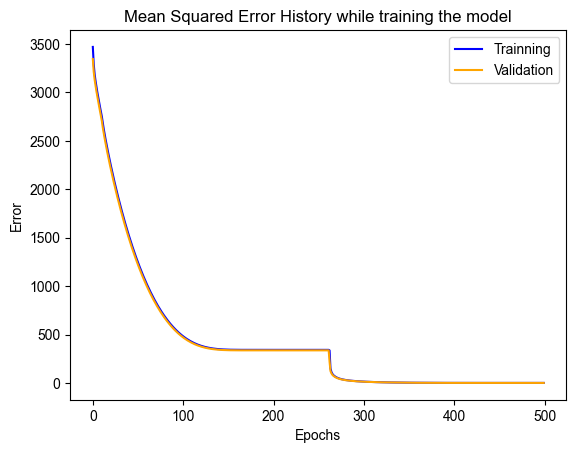

In [27]:
plt.plot(history.history['loss'],color='blue',label='Trainning')
plt.plot(history.history['val_loss'],color='orange',label='Validation')
plt.title('Mean Squared Error History while training the model')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
sns.set_style('whitegrid')
plt.show()

In [28]:
# Make predictions
predictions = model.predict(test_input)

99/99 [==============================] - 1s 1ms/step


In [29]:
predictions.shape

(3144, 1, 1)

In [30]:
test_soc.shape

(3144, 1)

In [31]:
test_soc = test_soc.reshape(3144,)
y_pred = predictions.reshape(3144,)

In [32]:
mse = mean_squared_error(test_soc, y_pred)
mae = mean_absolute_error(test_soc, y_pred)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(test_soc,y_pred)
r2 = r2_score(test_soc, y_pred)

In [33]:
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'Mean Absolute Percentage Error on Test Set: {mape*100}')
print(f'R2 Score : {r2}')

Mean Squared Error on Test Set: 0.11395253963379327
Root Mean Squared Error on Test Set: 0.3375685702694984
Mean Absolute Error on Test Set: 0.27834375578028553
Mean Absolute Percentage Error on Test Set: 0.8687676957982693
R2 Score : 0.9996759685030676


In [34]:
print(f'Time taken for fitting the model is {a/60} mins')

Time taken for fitting the model is 3.634639306863149 mins


In [35]:
Residual = test_soc - y_pred

In [36]:
df = pd.DataFrame({'Actual': test_soc , 'Predicted': y_pred}).sort_values('Actual',ascending=False)
df.head()

,Actual,Predicted
330,100.0,97.757301
1892,100.0,97.753769
2665,99.0,97.741966
2379,99.0,97.719719
820,99.0,97.747360


In [37]:
df.tail()

,Actual,Predicted
2145,1.0,1.522045
1688,1.0,1.902205
47,1.0,1.640187
1940,1.0,1.875685
2611,1.0,1.971390


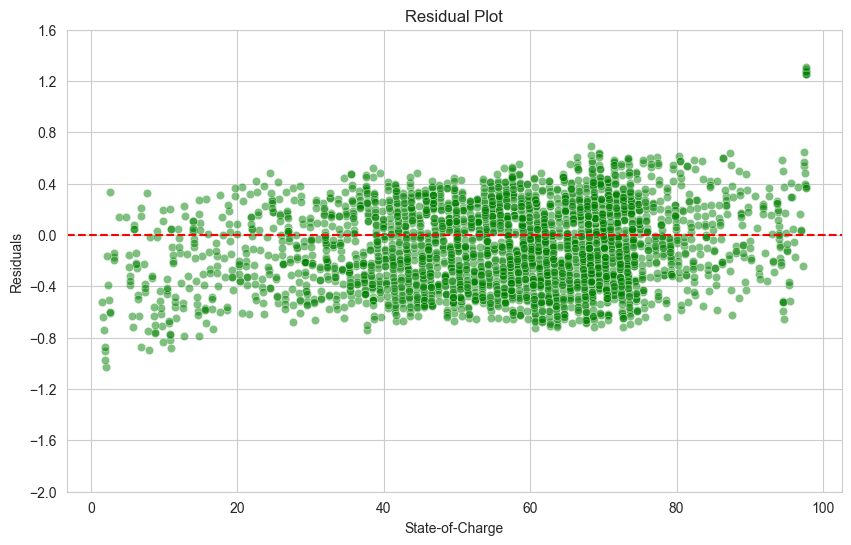

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=Residual, color='green',alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('State-of-Charge')
plt.ylabel('Residuals')
plt.ylim(-2, 1.5)  # Set y-axis limits
plt.yticks([i * 0.4 for i in range(-5, 5)])  # Set y-axis ticks
plt.show()

In [39]:
model.save("N10deg.h5")